In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
import os
import pandas as pd
from termcolor import colored
import numpy as np
from collections import OrderedDict
from collections import Counter
import matplotlib.pyplot as plt
from natsort import natsorted
import sys
import pickle
import seaborn as sns

# Display pandas df without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))



## Simple boxplot func

In [3]:
green_diamond = dict(markerfacecolor='g', marker='D')

def simple_boxplot(my_dict, fig_name, save_flag):
    fig, ax = plt.subplots(figsize=(20, 5), dpi=80)
    ax.boxplot(my_dict.values(), flierprops=green_diamond)
    ax.set_xticklabels(my_dict.keys())
    ax.grid()
    plt.ylim(-1, 50)
    plt.tight_layout()
    if save_flag:
        plt.savefig(fig_name+'.png')

In [4]:
def set_box_color(bp, edge_color, fill_color):
    plt.setp(bp['boxes'], color=edge_color)
    plt.setp(bp['whiskers'], color=edge_color)
    plt.setp(bp['caps'], color=edge_color)
    plt.setp(bp['medians'], color=edge_color)
    plt.setp(bp['fliers'], color=green_diamond)
#     for flier in bp['fliers']:
#         flier.set(marker='o', color=edge_color, alpha=1)
    
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

In [5]:
def boxplot_3dict(dictl, dictc, dictr, plotName):
    ticks = dictr.keys()

    fig, ax = plt.subplots(figsize=(20, 5), dpi=80)

    bpl = ax.boxplot(dictl.values(), patch_artist=True, flierprops=green_diamond, positions=np.array(range(len(dictl.values())))*3.0-0.6, widths=0.4)
    bpr = ax.boxplot(dictr.values(), patch_artist=True, flierprops=green_diamond, positions=np.array(range(len(dictr.values())))*3.0+0.6, widths=0.4)
    bpc = ax.boxplot(dictc.values(), patch_artist=True, flierprops=green_diamond, positions=np.array(range(len(dictc.values())))*3.0, widths=0.4)

    set_box_color(bpl, 'red', 'tan') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'blue', 'cyan')
    set_box_color(bpc, 'green', '#BCEE68')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label='Brownian')
    plt.plot([], c='green', label='Persistent')
    plt.plot([], c='blue', label='Adaptive')
    plt.legend(loc=1)

    # plt.xticks(range(0, 300, 5), ticks)
    # plt.xlim(-3, len(ticks)*3)
    # plt.ylim(0, 80)
    plt.xticks(range(0, len(ticks) * 3, 3), ticks)
    plt.xlim(-2, len(ticks)*3)

    ax.set_xticklabels(dictr.keys())
    ax.set_xlabel("Timeout[s]")
    ax.grid()

#     plt.tight_layout()
    # plt.savefig('boxcompare.png')
    figName = plotName + results_folder.split("/")[-1]+'.png'
    print("Figure name: ", figName)

    plt.savefig(figName)

In [6]:
num_robot = 24
experiment_time = 1800
num_run = 100

In [21]:
# results_folder = '/home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/standAlone/results_newWalkParam/brownian/Regions'
# results_folder = '/home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/standAlone/results_newWalkParam/persistent/Regions'
# results_folder = '/home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/standAlone/results_newWalkParam/adaptive/Regions'

# results_folder = '/home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/standAlone/results_newWalkParam/brownian/Mixed'
# results_folder = '/home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/standAlone/results_newWalkParam/persistent/Mixed'
results_folder = '/home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/standAlone/results_newWalkParam/adaptive/Mixed'

In [22]:
if not os.path.isdir(results_folder):
    print(colored("Error, " + results_folder + " does not exist", 'red'))
else:
    print(colored("OK, " + results_folder + " exists", 'green'))

OK, /home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/standAlone/results_newWalkParam/adaptive/Mixed exists


In [23]:
elpsTimeout_label = ['time', 'kID', 'areaID', 'areaColor']

In [24]:
elapsed_timeout_dict = {}

timeout = -1
for timeout_folder in natsorted(os.listdir(os.path.join(results_folder))):
    print(colored("Timeout folder:", 'blue'),timeout_folder)
    
    parameters = timeout_folder.split("_")
    
    for param in parameters:
        if param.startswith("timeout"):
#             print(param.split("#")[-1])
            timeout = int(param.split("#")[-1]) * 10
            print("\ttimeout:",timeout)
    
#     if timeout == 20 :
#         break
        
    if timeout == -1 :
        print(colored("\tWARNING: wrong timeout folder", 'green'))
        continue
        
    elapsed_timeout_count = []
    for filename in os.listdir(os.path.join(results_folder, timeout_folder)):
        if filename.endswith("elapsed_timeoutLOG.tsv"):
            if not os.path.getsize(os.path.join(results_folder, timeout_folder, filename)) > 0:
                print(colored("\tWARNING, empty file at:" + filename, 'red'))
                continue
#             print('\tfilename: ', filename)
            
            df_elpsTimeot = pd.read_csv(os.path.join(results_folder, timeout_folder, filename), sep="\t", header=None)
            df_elpsTimeot.columns = elpsTimeout_label
#             print(df_elpsTimeot['kID'].values)
            counter = Counter(df_elpsTimeot['kID'].values)
            
            for i in np.arange(num_robot):
                if i not in counter.keys():
#                     print("\t",i)
                    counter[i] = 0
            elapsed_timeout_count += list(counter.values())
#             print(elapsed_timeout_count)
    
    if len(elapsed_timeout_count):
        elapsed_timeout_dict[str(timeout)] = elapsed_timeout_count
    else:
        print(colored("\tWARNING: empty list!!", 'green'))
        elapsed_timeout_dict[str(timeout)] = [0] * num_robot * num_run
            


Timeout folder: Mixed_AdaptiveWalk_2021-07-13_robots#24_timeout#1_respawn#30_NumAreas#16_redAreas#8_1800#seconds
	timeout: 10
Timeout folder: Mixed_AdaptiveWalk_2021-07-13_robots#24_timeout#3_respawn#30_NumAreas#16_redAreas#8_1800#seconds
	timeout: 30
Timeout folder: Mixed_AdaptiveWalk_2021-07-13_robots#24_timeout#6_respawn#30_NumAreas#16_redAreas#8_1800#seconds
	timeout: 60
Timeout folder: Mixed_AdaptiveWalk_2021-07-13_robots#24_timeout#12_respawn#30_NumAreas#16_redAreas#8_1800#seconds
	timeout: 120
Timeout folder: Mixed_AdaptiveWalk_2021-07-13_robots#24_timeout#18_respawn#30_NumAreas#16_redAreas#8_1800#seconds
	timeout: 180
Timeout folder: Mixed_AdaptiveWalk_2021-07-13_robots#24_timeout#24_respawn#30_NumAreas#16_redAreas#8_1800#seconds
	timeout: 240
Timeout folder: Mixed_AdaptiveWalk_2021-07-13_robots#24_timeout#30_respawn#30_NumAreas#16_redAreas#8_1800#seconds
	timeout: 300
Timeout folder: Mixed_AdaptiveWalk_2021-07-13_robots#24_timeout#36_respawn#30_NumAreas#16_redAreas#8_1800#seco

In [25]:
elapsed_timeout_dict.keys()

dict_keys(['10', '30', '60', '120', '180', '240', '300', '360', '420', '480', '540', '600'])

In [26]:
print(len(elapsed_timeout_dict['10']))

2400


### Brownian

In [13]:
brownian_dict = elapsed_timeout_dict

### Persistent

In [20]:
persistent_dict = elapsed_timeout_dict

### Adaptive

In [27]:
adaptive_dict = elapsed_timeout_dict

Figure name:  elapsedTimeout_Mixed.png


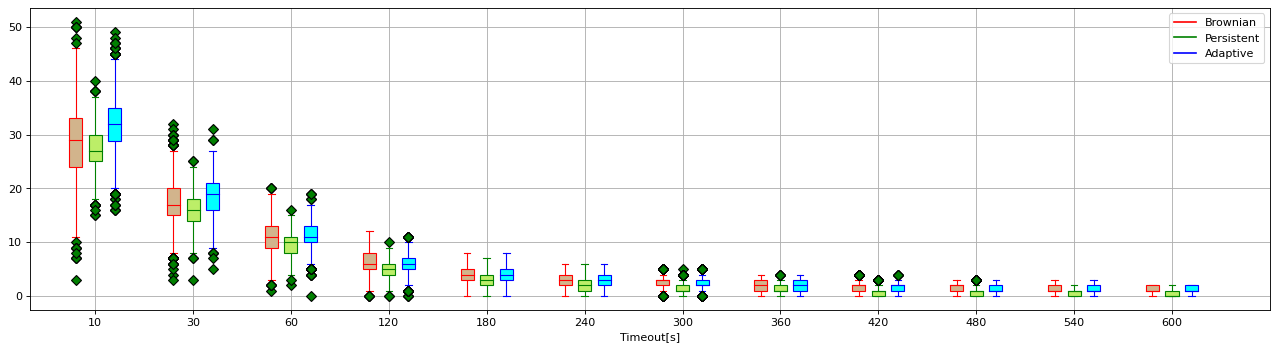

In [28]:
boxplot_3dict(brownian_dict, persistent_dict, adaptive_dict, "elapsedTimeout_")

### Brownian

In [ ]:
# saveFigure = True
# figName="elapsedTimeout_brownian_"+results_folder.split("/")[-1]
# print(figName)
# simple_boxplot(elapsed_timeout_dict, figName, saveFigure)

### Persistent

In [ ]:
# saveFigure = True
# figName="elapsedTimeout_persistent_"+results_folder.split("/")[-1]
# print(figName)
# simple_boxplot(elapsed_timeout_dict, figName, saveFigure)

## Adaptive

In [ ]:
# saveFigure = True
# figName="elapsedTimeout_adaptive_"+results_folder.split("/")[-1]
# print(figName)
# simple_boxplot(elapsed_timeout_dict, figName, saveFigure)